In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

In [2]:
digits = load_digits()
X = digits.data
y = digits.target
images = digits.images

print("Размер набора данных:", X.shape)
print("Количество классов:", len(np.unique(y)))

Размер набора данных: (1797, 64)
Количество классов: 10


In [3]:
def get_histogram(image, bins=16):
    # Диапазон яркости - от 0 до 16
    return np.histogram(image, bins=bins, range=(0, 16))[0]

def get_split_histogram(image, splits=4):
    h, w = image.shape
    # Разделение на 4 части фрагментами 2x2
    h_split = h // splits
    w_split = w // splits
    hist = []
    for i in range(splits):
        for j in range(splits):
            fragment = image[i*h_split:(i+1)*h_split, j*w_split:(j+1)*w_split]
            hist.extend(get_histogram(fragment, bins=4))
    return np.array(hist)

def get_magnitude(image):
    dx = np.gradient(image, axis=0)
    dy = np.gradient(image, axis=1)
    return np.sqrt(dx**2 + dy**2)

In [11]:
# Вектор характеристик - сами изображение
X_raw = X 
# Вектор характеристик - гистограммы интенсивности
X_hist = np.array([get_histogram(img) for img in images])
# Вектор характеристик - гистограммы интенсивности по фрагментам
X_split_hist = np.array([get_split_histogram(img) for img in images])
# Вектор характеристик - магнитуды градиента
X_magnitude = np.array([get_magnitude(img).flatten() for img in images])

datasets = {
    'raw_data': X_raw,
    'histogram': X_hist, 
    'split_histogram': X_split_hist,
    'magnitude': X_magnitude
}

In [26]:
def perform_kmeans(X, n_clusters=10, random_state=42):
    
    # Нормализация
    # X_normalized = (X - μ) / σ
    X_normalized = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)

    # Инициализация начальных центроидов
    # Перерасчет положения центроидов
    # Обучение модели
    # Назначение каждой точке ближайшего центроида
    labels = kmeans.fit_predict(X_normalized)
    
    return kmeans, labels

In [27]:
print("Проверка данных на NaN:")
print("X_raw:", np.isnan(X_raw).any())
print("X_hist:", np.isnan(X_hist).any())
print("X_split_hist:", np.isnan(X_split_hist).any())
print("X_magnitude:", np.isnan(X_magnitude).any())

Проверка данных на NaN:
X_raw: False
X_hist: False
X_split_hist: False
X_magnitude: False


In [32]:
clustering_results = {}
for name, data in datasets.items():
    kmeans, labels = perform_kmeans(data)
    clustering_results[name] = (kmeans, labels)

In [40]:
def map_clusters_to_labels(cluster_labels, true_labels):
    """
    Каждому кластеру присваивается тот класс (цифра), которая встречается в нем чаще всего
    """
    # Уникальные метки кластеров
    n_clusters = len(np.unique(cluster_labels))
    # Уникальные метки классов (10)
    n_classes = len(np.unique(true_labels))
    mapping_matrix = np.zeros((n_clusters, n_classes))

    # Матрица частот встречаемости классов в кластерах
    for i in range(len(true_labels)):
        mapping_matrix[cluster_labels[i], true_labels[i]] += 1
    
    # Определение наилучшего соответствия кластер->класс
    cluster_to_class = {}
    for cluster in range(n_clusters):
        # Класс с максимальным количеством точек в кластере
        true_class = np.argmax(mapping_matrix[cluster])
        cluster_to_class[cluster] = true_class
    return np.array([cluster_to_class[label] for label in cluster_labels])

def calculate_cluster_metrics(X, labels):
    n = len(X)
    F0_numerator = 0
    F0_denominator = 0
    F1_numerator = 0
    F1_denominator = 0

    for i in range(n):
        for j in range(n):
            distance = np.linalg.norm(X[i] - X[j])
            if labels[i] == labels[j]:
                F0_numerator += distance
                F0_denominator += 1
            else:
                F1_numerator += distance
                F1_denominator += 1

    # Среднеее внутрикластерное расстояние
    F0 = F0_numerator / F0_denominator if F0_denominator > 0 else 0
    # Среднее межкластерное расстояние
    F1 = F1_numerator / F1_denominator if F1_denominator > 0 else 0

    return F0, F1

evaluation_results = {}
for name, (kmeans, labels) in clustering_results.items():
    # Преобразование меток кластеров в предсказанные классы
    predicted_labels = map_clusters_to_labels(labels, y)
    
    intra_cluster, inter_cluster = calculate_cluster_metrics(datasets[name], labels)
    conf_matrix = confusion_matrix(y, predicted_labels)
    
    evaluation_results[name] = {
        'intra_cluster': intra_cluster,
        'inter_cluster': inter_cluster,
        'confusion_matrix': conf_matrix,
        'predicted_labels': predicted_labels
    }

# Вывод результатов
for name, metrics in evaluation_results.items():
    print(f"\nРезультаты для {name}:")
    print(f"Среднее внутрикластерное расстояние (F0): {metrics['intra_cluster']:.2f}")
    print(f"Среднее межкластерное расстояние (F1): {metrics['inter_cluster']:.2f}")
    print(f"Отношение F1/F0: {metrics['inter_cluster']/metrics['intra_cluster']:.2f}")
    print("\nМатрица ошибок:")
    print(metrics['confusion_matrix'])


Результаты для raw_data:
Среднее внутрикластерное расстояние (F0): 37.01
Среднее межкластерное расстояние (F1): 50.14
Отношение F1/F0: 1.35

Матрица ошибок:
[[176   0   0   0   2   0   0   0   0   0]
 [  0   1  27   0  49   0   0   0 105   0]
 [  1   0 141   5   3   0   0   1  26   0]
 [  0   0   1 160   0   8   0   7   7   0]
 [  0   1   0   0 155   0   0  23   2   0]
 [  0   0   0  52   3 120   3   1   3   0]
 [  1   0   0   0   0   0 175   0   5   0]
 [  0   0   0   0   2   2   0 174   1   0]
 [  0   0   1  50   3   6   2   4 108   0]
 [  0   0   0 146  15   3   0  14   2   0]]

Результаты для histogram:
Среднее внутрикластерное расстояние (F0): 7.75
Среднее межкластерное расстояние (F1): 9.22
Отношение F1/F0: 1.19

Матрица ошибок:
[[ 97  13   0   0  29   0  21  18   0   0]
 [  1 117   0   0  41   0  10  13   0   0]
 [ 20  33   0   0  74   0  31  19   0   0]
 [ 26  20   0   0  75   0  48  14   0   0]
 [  9  36   0   0  87   0  38  11   0   0]
 [ 34  46   0   0  54   0  29  19   0  

In [34]:
def calculate_metrics(y_true, y_pred):

    classes = np.unique(y_true)
    n_classes = len(classes)
    
    accuracy = np.zeros(n_classes)
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1 = np.zeros(n_classes)
    alpha = np.zeros(n_classes)  
    beta = np.zeros(n_classes)   
    
    # Расчет метрик для каждого класса
    for i, class_label in enumerate(classes):

        # Бинаризация меток
        true_bin = (y_true == class_label)
        pred_bin = (y_pred == class_label)
        
        TP = np.sum((true_bin) & (pred_bin))
        FP = np.sum((y_true != class_label) & (pred_bin))
        TN = np.sum((y_true != class_label) & (y_pred != class_label))
        FN = np.sum((true_bin) & (y_pred != class_label))
        
        accuracy[i] = (TP + TN) / (TP + TN + FP + FN)
        precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
        alpha[i] = FP / (FP + TN) if (FP + TN) > 0 else 0  
        beta[i] = FN / (TP + FN) if (TP + FN) > 0 else 0   
    
    return {
        'accuracy': np.mean(accuracy),
        'precision': np.mean(precision),
        'recall': np.mean(recall),
        'f1': np.mean(f1),
        'alpha': np.mean(alpha),
        'beta': np.mean(beta)
    }

for name, metrics in evaluation_results.items():
    predicted_labels = metrics['predicted_labels']
    classification_metrics = calculate_metrics(y, predicted_labels)
    
    print(f"\nМетрики для {name}:")
    print(f"Accuracy: {classification_metrics['accuracy']:.3f}")
    print(f"Precision: {classification_metrics['precision']:.3f}")
    print(f"Recall: {classification_metrics['recall']:.3f}")
    print(f"F1 Score: {classification_metrics['f1']:.3f}")
    print(f"Ошибка I рода (alpha): {classification_metrics['alpha']:.3f}")
    print(f"Ошибка II рода (beta): {classification_metrics['beta']:.3f}")


Метрики для raw_data:
Accuracy: 0.935
Precision: 0.640
Recall: 0.674
F1 Score: 0.618
Ошибка I рода (alpha): 0.036
Ошибка II рода (beta): 0.326

Метрики для histogram:
Accuracy: 0.842
Precision: 0.103
Recall: 0.209
F1 Score: 0.135
Ошибка I рода (alpha): 0.088
Ошибка II рода (beta): 0.791

Метрики для split_histogram:
Accuracy: 0.923
Precision: 0.539
Recall: 0.615
F1 Score: 0.560
Ошибка I рода (alpha): 0.043
Ошибка II рода (beta): 0.385

Метрики для magnitude:
Accuracy: 0.926
Precision: 0.623
Recall: 0.631
F1 Score: 0.608
Ошибка I рода (alpha): 0.041
Ошибка II рода (beta): 0.369


In [35]:
best_metrics = {
    'accuracy': {'value': 0, 'method': ''},
    'precision': {'value': 0, 'method': ''},
    'recall': {'value': 0, 'method': ''},
    'f1': {'value': 0, 'method': ''},
    'alpha': {'value': float('inf'), 'method': ''},  
    'beta': {'value': float('inf'), 'method': ''}
}

for name, metrics in evaluation_results.items():
    predicted_labels = metrics['predicted_labels']
    current_metrics = calculate_metrics(y, predicted_labels)
    
    for metric_name in best_metrics.keys():
        current_value = current_metrics[metric_name]
        
        if metric_name in ['alpha', 'beta']:  
            if current_value < best_metrics[metric_name]['value']:
                best_metrics[metric_name]['value'] = current_value
                best_metrics[metric_name]['method'] = name
        else:  
            if current_value > best_metrics[metric_name]['value']:
                best_metrics[metric_name]['value'] = current_value
                best_metrics[metric_name]['method'] = name

print("\nЛучшие метрики для каждого метода:")
print("-" * 50)
for metric_name, data in best_metrics.items():
    print(f"{metric_name.capitalize()}:")
    print(f"Значение: {data['value']:.3f}")
    print(f"Метод: {data['method']}")
    print("-" * 50)


Лучшие метрики для каждого метода:
--------------------------------------------------
Accuracy:
Значение: 0.935
Метод: raw_data
--------------------------------------------------
Precision:
Значение: 0.640
Метод: raw_data
--------------------------------------------------
Recall:
Значение: 0.674
Метод: raw_data
--------------------------------------------------
F1:
Значение: 0.618
Метод: raw_data
--------------------------------------------------
Alpha:
Значение: 0.036
Метод: raw_data
--------------------------------------------------
Beta:
Значение: 0.326
Метод: raw_data
--------------------------------------------------


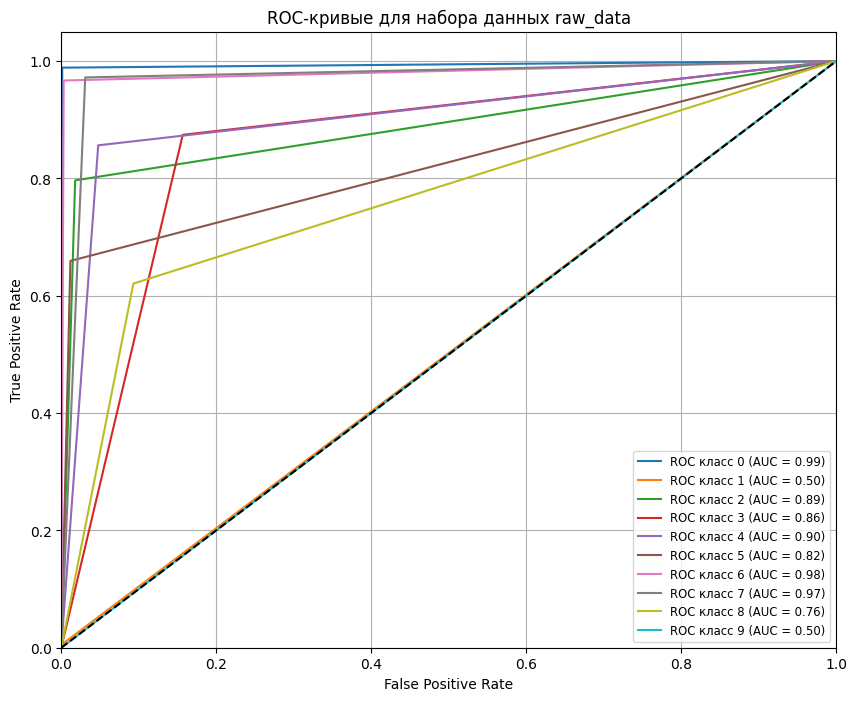

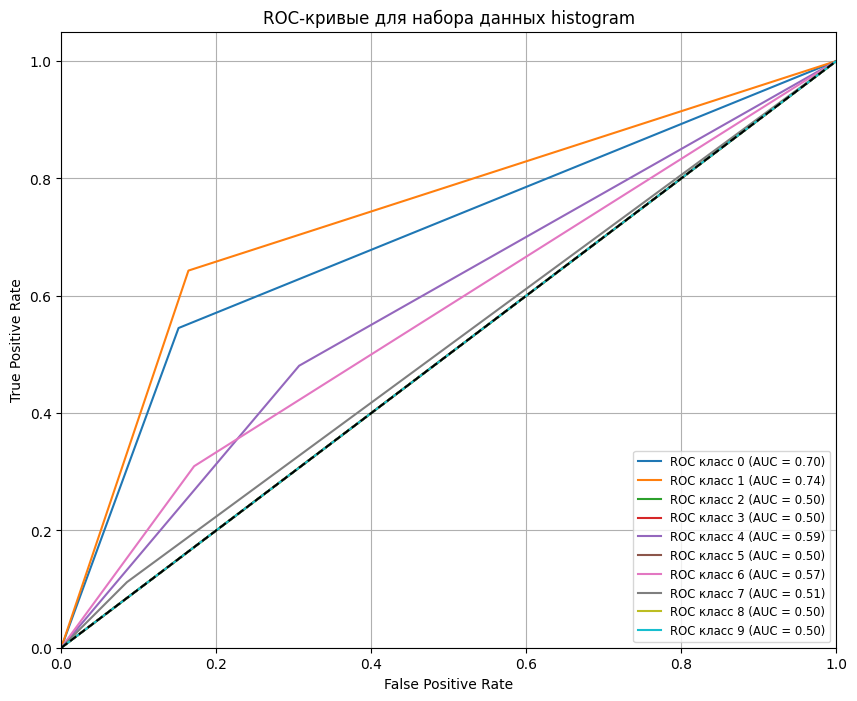

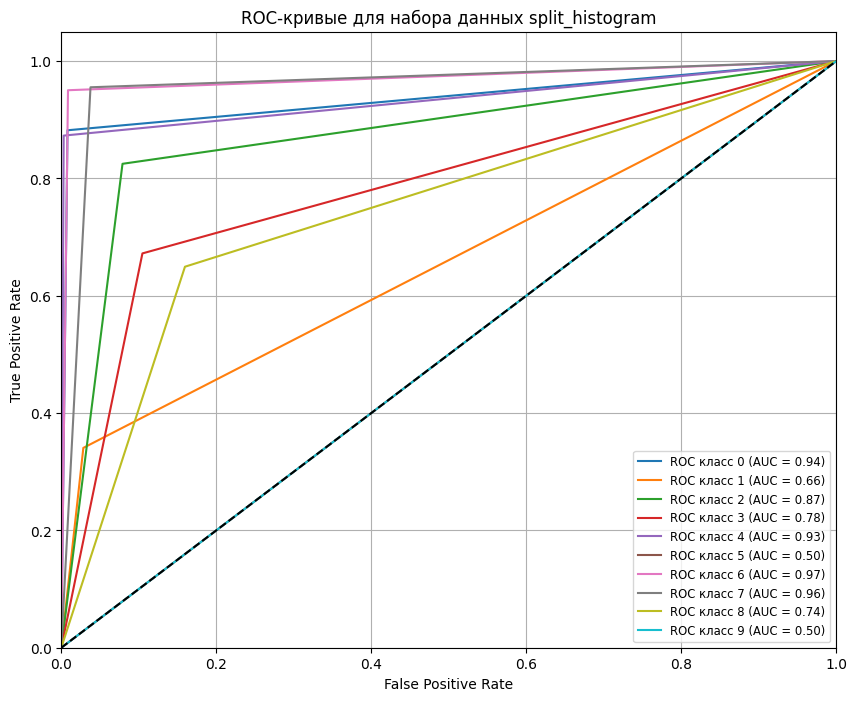

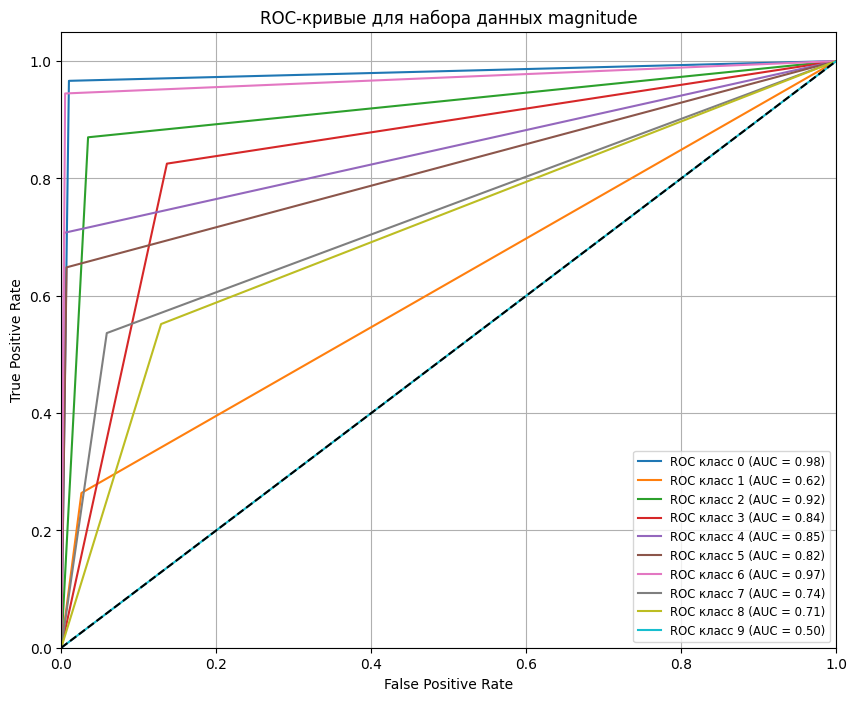

In [41]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_pred_scores, method_name):

    # Бинаризация меток
    n_classes = 10
    y_test_bin = label_binarize(y_true, classes=range(n_classes))
    y_pred_bin = label_binarize(y_pred_scores, classes=range(n_classes))
    
    plt.figure(figsize=(10, 8))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'ROC класс {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривые для набора данных {method_name}')
    plt.legend(loc="lower right", fontsize='small')
    plt.grid(True)
    plt.show()

for name, metrics in evaluation_results.items():
    predicted_labels = metrics['predicted_labels']
    plot_roc_curves(y, predicted_labels, name)